In [1]:

import os
import csv


samples = [] 

with open('./data/driving_log.csv') as csvfile: 
    reader = csv.reader(csvfile)
    next(reader, None) 
    for line in reader:
        samples.append(line)

        

print("done")

done


In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(samples,test_size=0.2) 

In [3]:
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt

#building the generator function
def generator(samples, batch_size=32):
    num_samples = len(samples)
   
    while 1: #Loop forever so that the generator never terminates
        shuffle(samples) 
        for offset in range(0, num_samples, batch_size):
            
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                    for i in range(0,3): # taking 3 images - centre, left and right
                        
                        name = './data/IMG/'+batch_sample[i].split('/')[-1]
                        center_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB) # converting it to RGB 
                        center_angle = float(batch_sample[3]) # getting the steering angle 
                        images.append(center_image)
                        
                        
                        if(i==0):
                            angles.append(center_angle)
                        elif(i==1):
                            angles.append(center_angle+0.2) #increasing the steering angle by 0.2 for left images
                        elif(i==2):
                            angles.append(center_angle-0.2) #decreasing the steering angle by 0.2 for right images
                        
                        # performing data augmentation by flipping the image and inversing the sign
                        # of the corresponding steering angle
                        
                        images.append(cv2.flip(center_image,1))
                        if(i==0):
                            angles.append(center_angle*-1)
                        elif(i==1):
                            angles.append((center_angle+0.2)*-1)
                        elif(i==2):
                            angles.append((center_angle-0.2)*-1)
                          
                        
        
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield sklearn.utils.shuffle(X_train, y_train) 
            

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers import Lambda, Cropping2D


# Building the model 
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3))) # Normalization
model.add(Cropping2D(cropping=((60,25),(0,0)))) #trimming image to focus on the road portion   




# three layers of Convolution of channel sizes 24, 36 and 48, filter size= 5x5, stride= 2x2 as per the suggestions
model.add(Convolution2D(24,5,5,subsample=(2,2)))
model.add(Activation('relu'))

model.add(Convolution2D(36,5,5,subsample=(2,2)))
model.add(Activation('relu'))

model.add(Convolution2D(48,5,5,subsample=(2,2)))
model.add(Activation('relu'))




# convolution with no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Convolution2D(64,3,3))
model.add(Activation('relu'))

model.add(Convolution2D(64,3,3))
model.add(Activation('relu')) # using elu to reduce vanishing gradient

model.add(Flatten())

# fully connected layers [100, 50, 10, 1] as per the suggestions

# fully connected layer 
model.add(Dense(100))
model.add(Activation('relu'))

# adding a dropout layer with keep probability 0.5 to reduce overfitting
model.add(Dropout(0.5))

# fully connected layer 
model.add(Dense(50))
model.add(Activation('relu'))

# fully connected layer 
model.add(Dense(10))
model.add(Activation('relu'))

# fully connected layer 
model.add(Dense(1)) 


# using mean square error and adam optimizer
model.compile(loss='mse',optimizer='adam')


# training the model with fit_generator
# no of epochs : 5

model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator,   nb_val_samples=len(validation_samples), nb_epoch=5, verbose=1)

#saving the model
model.save('model2.h5')

print(' Model saved ..')

# keras method to print the model summary
model.summary()

c:\users\mosen\elilly\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2))`
  app.launch_new_instance()
c:\users\mosen\elilly\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2))`
c:\users\mosen\elilly\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2))`
c:\users\mosen\elilly\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
c:\users\mosen\elilly\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
c:\users\mosen\elilly\lib\site-packages\ipykernel_launcher.py:65: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`

Epoch 1/5
  59/6428 [..............................] - ETA: 3:31:54 - loss: 0.0241

KeyboardInterrupt: 

In [9]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_2 (Cropping2D)    (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 158, 24)       1824      
_________________________________________________________________
activation_9 (Activation)    (None, 36, 158, 24)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 77, 36)        21636     
_________________________________________________________________
activation_10 (Activation)   (None, 16, 77, 36)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 37, 48)        

In [17]:
image = generator(train_samples, batch_size=1)

In [19]:
image = cv2.imread('./data/IMG/center_2016_12_01_13_30_48_287.jpg')

In [21]:
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

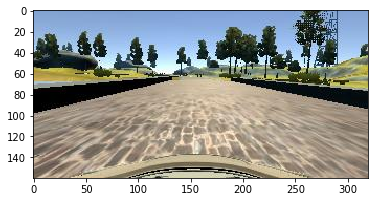

In [22]:
plt.imshow(img)

In [23]:
img2 = (img/255.0)-0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


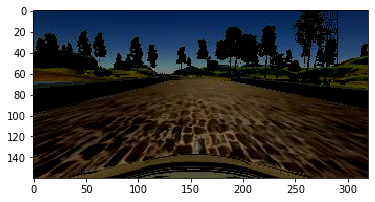

In [24]:
plt.imshow(img2)

In [25]:
img_cropped = img2[60:-24, :]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


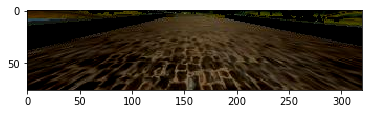

In [26]:
plt.imshow(img_cropped)